# ガウス過程回帰の一般化

## 最適化手法
### ラプラス近似

### EP法

## 分類問題
### ロジスティック回帰
#### モデル概要
入力$x$と教師データ$t$との関係を以下のようにモデル化します
$$
p(t_i | \omega)  = \sigma(\omega^T x_i)^{t_i} (1 - \sigma(\omega^T x_i))^{1-t_i} \\
$$
つまり，$t_i$が1のときは$\sigma(\omega^T x_i)$，0のときは$1 - \sigma(\omega^T x_i)$となる確率分布に従うとします．(ベルヌーイ分布)

教師ありデータセットが得られたとき，$t$の同時分布に関する対数尤度は
$$
\log p(t | \omega) = \sum_{i=1}^N \{ t_i \log \sigma(\omega^T x_i) + (1 - t_i) \log (1 - \sigma(\omega^T x_i)) \}
$$
となり交差エントロピーとなります．これを最大化することがロジスティック回帰となります．

sklearnを用いて実装をしていきます．

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# データ生成
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, random_state=1)

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# データのスケーリング
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

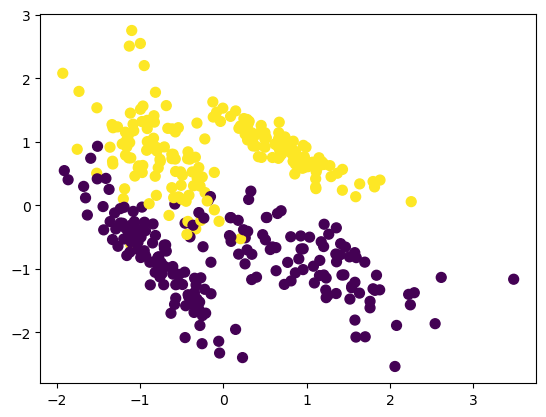

In [37]:
# データの可視化
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', s=50)
plt.show()

In [38]:
# ロジスティック回帰モデルの学習
model = LogisticRegression()
model.fit(X_train, y_train)

# テストデータに対する予測
y_pred = model.predict(X_test)

# 結果の評価
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.93


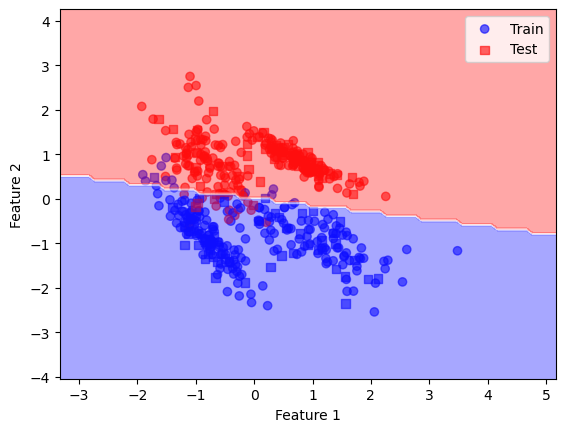

In [39]:
# 散布図の描画
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', alpha=0.6, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='bwr', alpha=0.6, marker='s', label='Test')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# 決定境界の描画
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1), np.arange(x2_min, x2_max, 0.1))
Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)
plt.contourf(xx1, xx2, Z, alpha=0.4, cmap='bwr')

plt.show()


### ベイズロジスティック回帰
#### モデル概要
入力$x$と教師データ$t$との関係を以下のようにモデル化します
$$
p(t_i | \omega)  = \sigma(\omega^T x_i)^{t_i} (1 - \sigma(\omega^T x_i))^{1-t_i} \\
$$
つまり，$t_i$が1のときは$\sigma(\omega^T x_i)$，0のときは$1 - \sigma(\omega^T x_i)$となる確率分布に従うとします．(ベルヌーイ分布)

教師ありデータセットが得られたとき，$t$の同時分布に関する対数尤度は
$$
\log p(t | \omega) = \sum_{i=1}^N \{ t_i \log \sigma(\omega^T x_i) + (1 - t_i) \log (1 - \sigma(\omega^T x_i)) \}
$$
となり交差エントロピーとなります．これを最大化することがロジスティック回帰となります．

ベイズロジスティック回帰はここから，事前分布$p(\omega)$を導入することでベイズ的にモデル化したものです．

実装には主にPyMC3を用います

データの生成：https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
# make_classificationはサンプル数や特徴量数などのいくつかのパラメータを指定することで，簡単に分類用のサンプルデータを生成します．
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [20]:
'''
features:特徴量数
informative:分類に有用な特徴量数
redundant:分類に無用な特徴量数
'''
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

データの確認作業

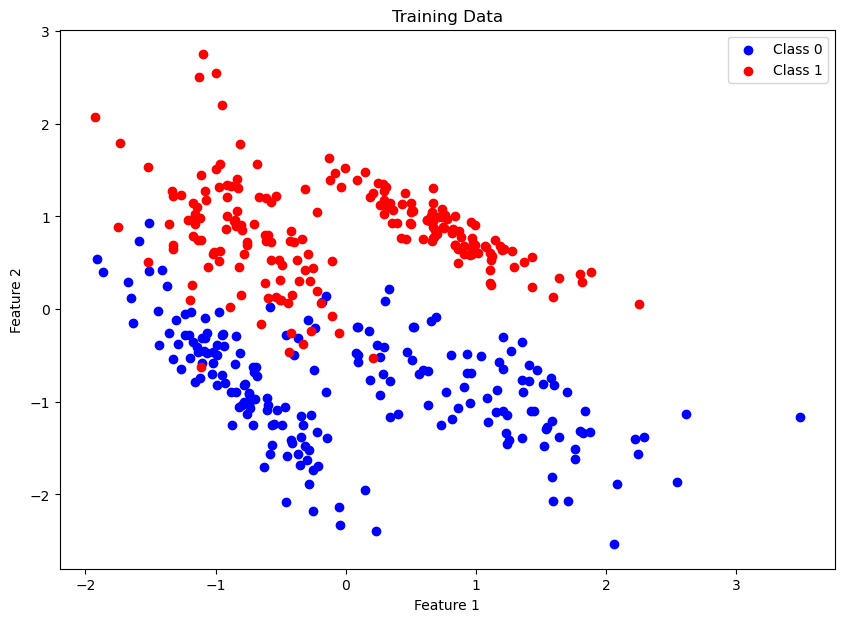

In [21]:
# プロット
plt.figure(figsize=(10, 7))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='blue', label='Class 0')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='red', label='Class 1')

# ラベルの追加
plt.title('Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# 表示
plt.show()

#### ラプラス近似によるベイズロジスティック回帰

In [29]:
# モデルの定義
with pm.Model() as logistic_model:
    # 事前分布の設定
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train.shape[1])
    # 線形予測子
    mu = alpha + pm.math.dot(X_train, beta)
    # ロジスティック関数
    theta = pm.math.sigmoid(mu)
    # 推定値
    observed = pm.Bernoulli('observed', p=theta, observed=y_train)

    # MAP推定値を計算
    map_estimate = pm.find_MAP()
    
    # メトロポリスサンプリングを用いて近似
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=map_estimate, chains=2, cores=2)


 /tmp/ipykernel_2942455/3592100365.py:18: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 0 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


 /home/mori/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning:Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


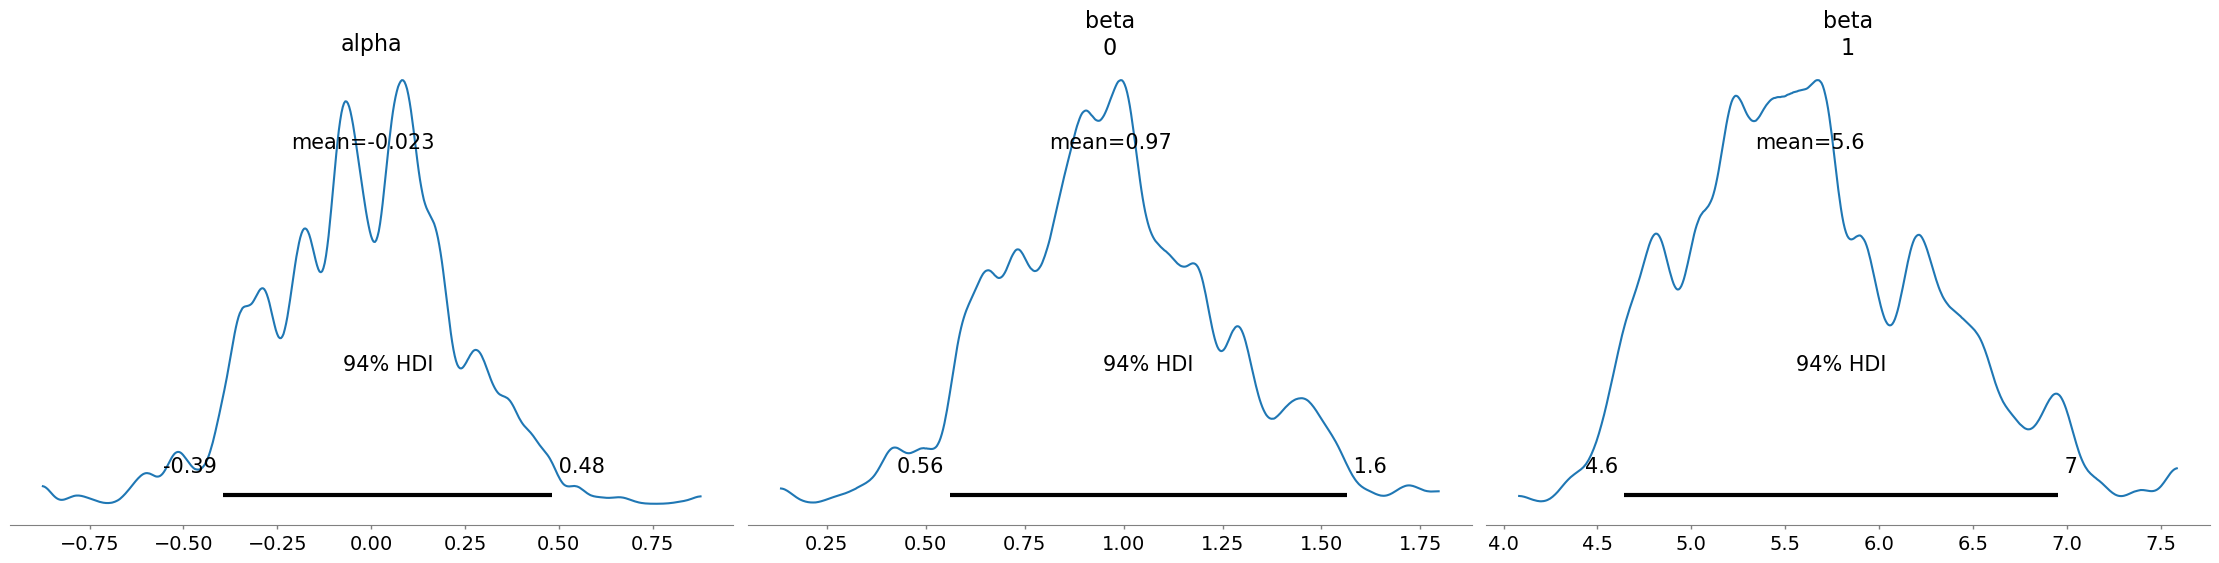

In [30]:
# alphaとbetaの事後分布をプロット
pm.plot_posterior(trace, var_names=['alpha', 'beta'])
plt.show()

#### MCMCによる事後分布の推定

In [24]:
# モデルの構築
with pm.Model() as logistic_model:
    # 事前分布の設定
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train.shape[1])
    # 線形予測子
    mu = alpha + pm.math.dot(X_train, beta)
    # ロジスティック関数
    theta = pm.math.sigmoid(mu)
    # 推定値
    observed = pm.Bernoulli('observed', p=theta, observed=y_train)
    # MCMCサンプリングを適用して，パラメータの事後分布を推定
    trace = pm.sample(1000, tune=1000, chains=2, cores=2)

 /tmp/ipykernel_2942455/4089431501.py:13: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 0 seconds.


事後分布に関するサンプリングの結果を可視化しましょう．

左側のサブプロットはカーネル密度推定（KDE）プロットで、サンプルの事後分布を表示します．これは各パラメータの確率分布を表し，分布がどのような形状をしているか（例：正規分布、歪んだ分布など），また最も確率が高いパラメータの値がどれくらいかを把握するのに役立ちます．

右側のサブプロットはトレースプロットで，MCMCサンプリング中に各ステップで取得されたサンプル値を表示します．これはサンプリングがどのように動作しているかを示し，MCMCアルゴリズムが収束しているかどうかの手がかりを提供します．

 /home/mori/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning:Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


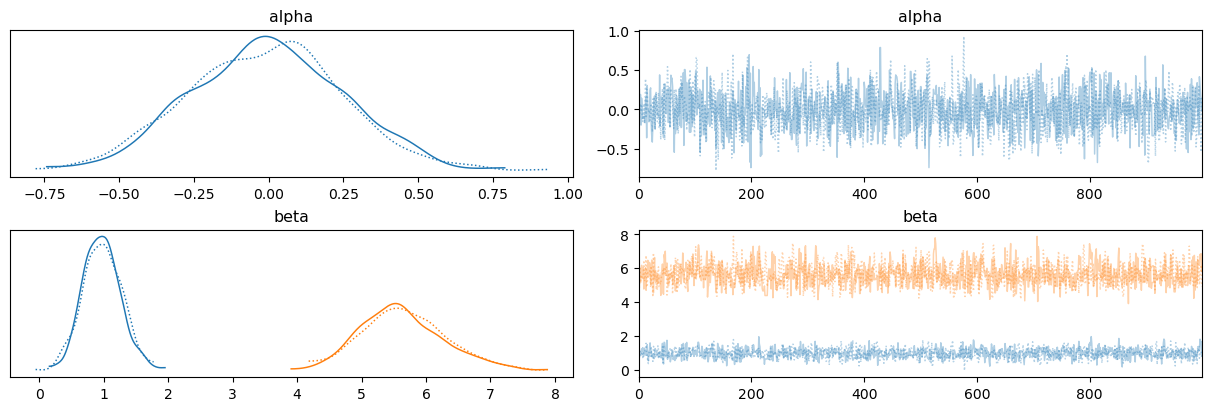

In [25]:
# 結果の可視化
pm.traceplot(trace)
plt.show()

In [26]:
# 予測
with logistic_model:
    ppc = pm.sample_posterior_predictive(trace, samples=100)
    predictions = ppc['observed'].mean(axis=0) > 0.5

# 評価
accuracy = (predictions == y_train).mean()
print(f'Accuracy: {accuracy:.2f}')

 /home/mori/anaconda3/lib/python3.10/site-packages/pymc3/sampling.py:1689: UserWarning:samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample


Accuracy: 0.94


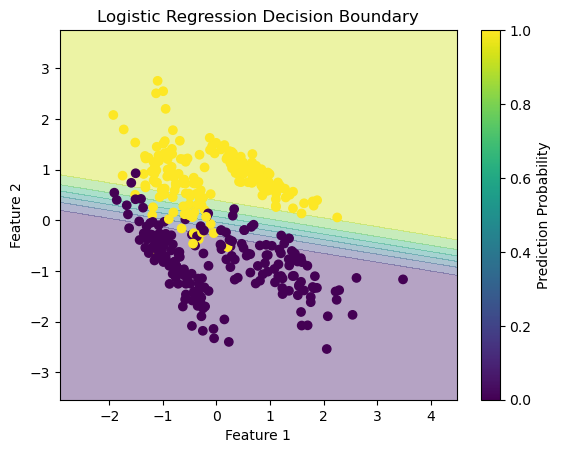

In [27]:
# 予測
alpha_mean = np.mean(trace['alpha'])
beta_mean = np.mean(trace['beta'], axis=0)
def predict(x):
    return 1 / (1 + np.exp(-(alpha_mean + np.dot(x, beta_mean))))

# プロット
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = np.array([predict(x) for x in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Logistic Regression Decision Boundary")
plt.colorbar(label='Prediction Probability')
plt.show()

上のカラーマップは，黄色に近いほど赤色である確率が高く，紫に近いほど青色である確率が高いことを示します．

/home/mori/anaconda3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


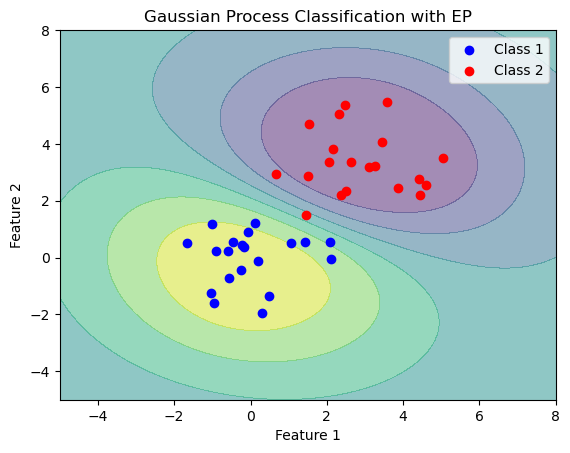

In [1]:
import numpy as np
import GPy
import matplotlib.pyplot as plt

# サンプルデータを生成します。
# クラス1のデータ
X1 = np.random.randn(20, 2)
Y1 = np.ones((20, 1))

# クラス2のデータ
X2 = np.random.randn(20, 2) + 3
Y2 = np.zeros((20, 1))

# データを結合します。
X = np.vstack((X1, X2))
Y = np.vstack((Y1, Y2))

# ガウス過程分類モデルを作成します。
kernel = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1.)
model = GPy.models.GPClassification(X, Y, kernel=kernel)

# EP法を使用して最適化します。
model.optimize('bfgs', max_iters=100)

# 新しいデータ点の予測を行います。
x_test = np.linspace(-5, 8, 100).reshape(-1, 1)
y_test = np.linspace(-5, 8, 100).reshape(-1, 1)
x_test_grid, y_test_grid = np.meshgrid(x_test, y_test)
X_test = np.vstack((x_test_grid.ravel(), y_test_grid.ravel())).T
probs, _ = model.predict(X_test)

# 予測をプロットします。
plt.contourf(x_test_grid, y_test_grid, probs.reshape(100, 100), alpha=0.5)
plt.scatter(X1[:, 0], X1[:, 1], c='blue', label='Class 1')
plt.scatter(X2[:, 0], X2[:, 1], c='red', label='Class 2')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gaussian Process Classification with EP')
plt.show()

## ポアソン回帰適用